In [1]:
import numpy
import matplotlib.pyplot as plt
import h5py
from scipy import ndimage  
from scipy import signal
import time
from PIL import Image
from skimage.morphology import convex_hull_image
from scipy.optimize import minimize

from sscPimega import misc
from sscPimega import pi540D
from sscIO import io

#%matplotlib notebook
import matplotlib
#from ipywidgets import *

In [2]:
EMA=True
if EMA:
    distance = 0
    data = h5py.File('ema_nov_2021.hdf5','r')['entry/data/data'][0,0,:,:]

    #files = ['540d3_1s_al2o3.hdf5', '540d3_20cm.hdf5', '540d3_300s_th40.hdf5']
    #path = '/home/ABTLUS/eduardo.miqueles/ema/'+files[1]
    #data = h5py.File(path,'r')['entry/data/data'][0,0,:,:]

In [3]:
def polar2cart(r, theta):
    return r*numpy.cos(theta), r*numpy.sin(theta)

def cart2polar(x, y):
    return numpy.arctan2(y,x), numpy.sqrt(x**2 + y**2)

def toPolar(cart, ac, ap, xc, yc, R, V):

    n       = cart.shape[0]
    dxy     = (2*ac)/float(n-1)
    m_angle = numpy.linspace(0,2*numpy.pi,V)
    m_ray   = numpy.linspace(0,ap,R)
    theta,R = numpy.meshgrid(m_angle, m_ray)
    X,Y     = polar2cart(R, theta)
    X       = X + (-ac + xc * dxy )
    Y       = Y + (-ac + yc * dxy )
    iX      = ((X+ac)/dxy).astype(int)
    iY      = ((Y+ac)/dxy).astype(int)

    iX[ iX >= n] = n-1
    iX[ iX < 0 ] = 0
    iY[ iY >= n] = n-1
    iY[ iY < 0]  = 0

    #nearest neighbourhood
    nearest = cart[iY,iX]
    polar   = nearest

    return polar

/home/ABTLUS/eduardo.miqueles/.local/lib/python3.6/site-packages/sscPimega-0.0.3-py3.6-linux-ppc64le.egg/sscPimega/pi540D/pi540D.py:5718: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Gaps  = numpy.array( [ params['gaps'][0], params['gaps'][1], params['gaps'][2], params['gaps'][3] ]  )


(3580, 3580)


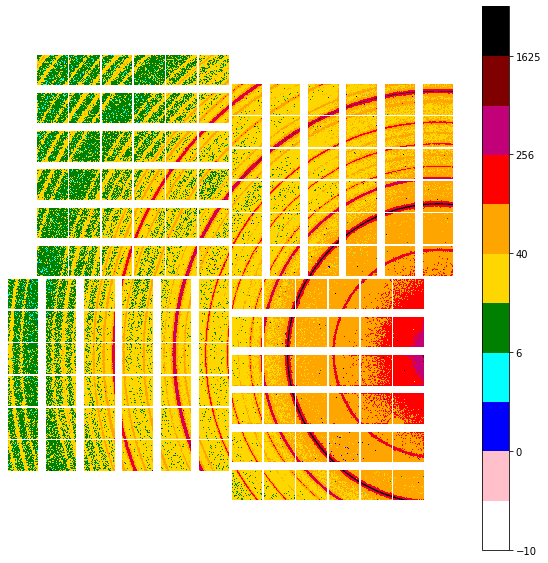

In [4]:
project      = pi540D.get_detector_dictionary( distance, {'geo':'planar','opt':False,'mode':'real'} )
project['s'] = [ 5, 5 ]
geometry     = pi540D.geometry540D( project )

rest = pi540D.backward540D( data, geometry, )

#roi = 256
#misc.imshow(rest[1536-roi:1536+roi,1536-roi:1536+roi], (10,10))

misc.imshow( rest, (10,10) )

#plt.figure(figsize=(10,10))
#plt.imshow( rest, vmin=0, vmax=1000)

print(rest.shape)

NameError: name 'interact' is not defined

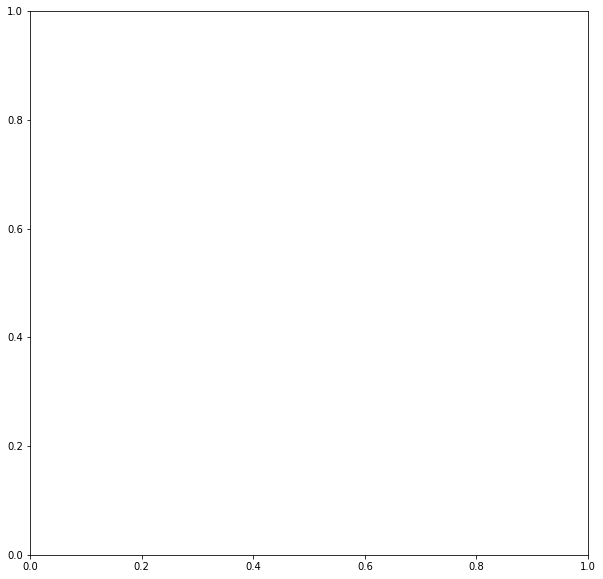

In [26]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)

def update(xc, yc):
    ax.clear()
    m = 256 #for visualization only
    P = toPolar(rest, 1, 1, xc, yc, m, m)
    ax.imshow(P, norm=matplotlib.colors.LogNorm())

    fig.canvas.draw_idle()


interact(update, 
         xc=widgets.IntSlider(min=0, max=rest.shape[0], step=1, value = 3444),
         yc=widgets.IntSlider(min=0, max=rest.shape[0], step=1, value = 2402) )

In [5]:
xc   = 3444
yc   = 2402
susp = 5

hexa = []
phexa = []
curve = []
for k in range(24):
    params       = {'geo':'planar','opt':True,'mode':'real','hexa':[k] }
    project      = pi540D.get_detector_dictionary( distance, params)
                                                   
    project['s'] = [ susp, susp ]
    geometry     = pi540D.geometry540D( project )

    hexa.append ( pi540D.backward540D( data, geometry ) )
    phexa.append( toPolar(hexa[k], 1, 1, xc, yc, 3580, 3580 ) )

    tmp = phexa[k]
    tmp[tmp<0] = -1
    curve.append( tmp.sum(1) )
    #print(k)

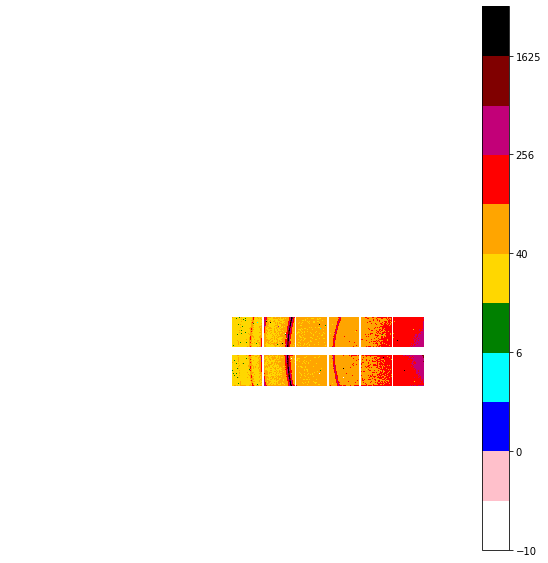

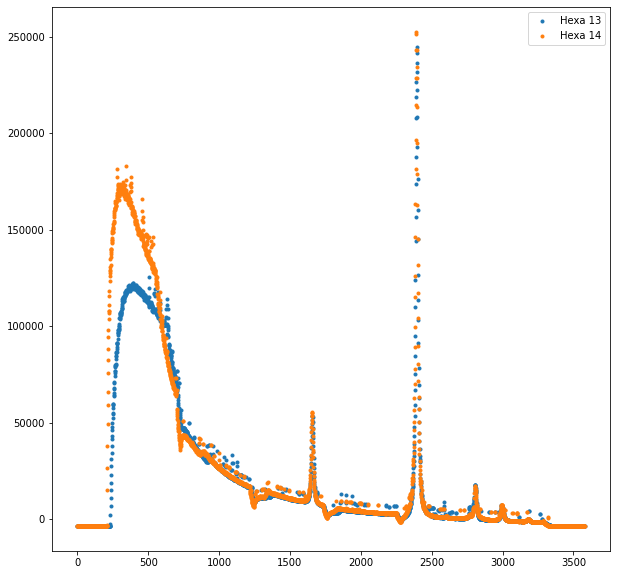

In [6]:
_set_ = [13,14]

H = 0
for k in _set_:
    H+=hexa[k]

misc.imshow( H, (10,10))

plt.figure(figsize=(10,10))
for k in _set_:
    plt.plot(curve[k], '.', label='Hexa {}'.format(k))
plt.legend()

# Templates for image callibration & restoration

array([-10.        ,  -0.1       ,   0.        ,   1.08140293,
         1.16943229,   1.2646275 ,   1.36757187,   1.47889623,
         1.5992827 ,   1.729469  ,   1.87025283,   2.02249694])

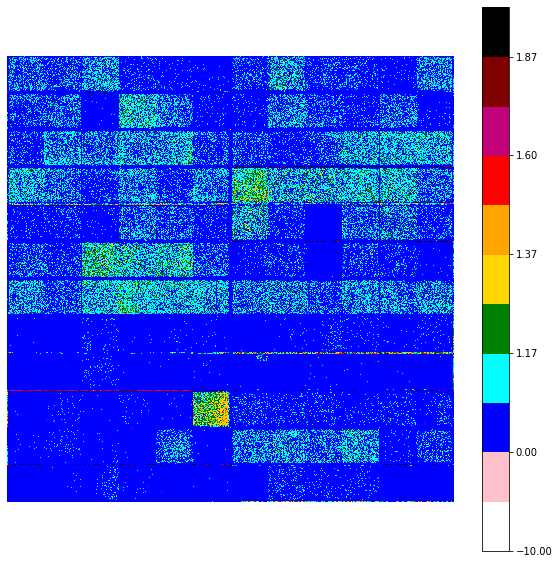

In [7]:
flat = numpy.load('calMarch2022/flatFeb2022.npy')
data = h5py.File('calMarch2022/300mm_1s.hdf5','r')['entry/data/data/'][0,0,:,:]



array([-10.        ,  -0.1       ,   0.        ,   1.08140293,
         1.16943229,   1.2646275 ,   1.36757187,   1.47889623,
         1.5992827 ,   1.729469  ,   1.87025283,   2.02249694])

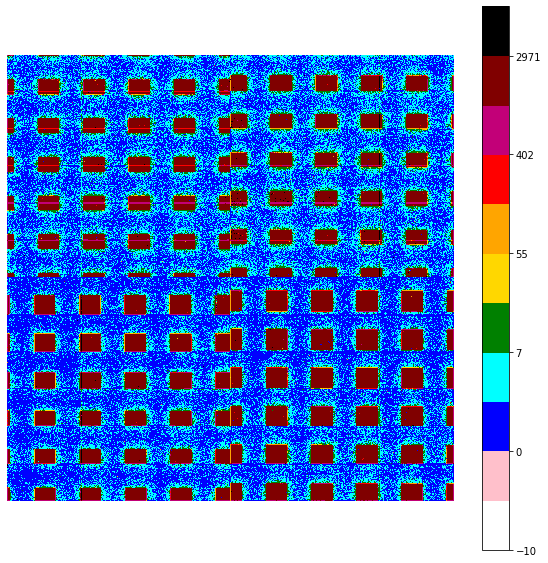

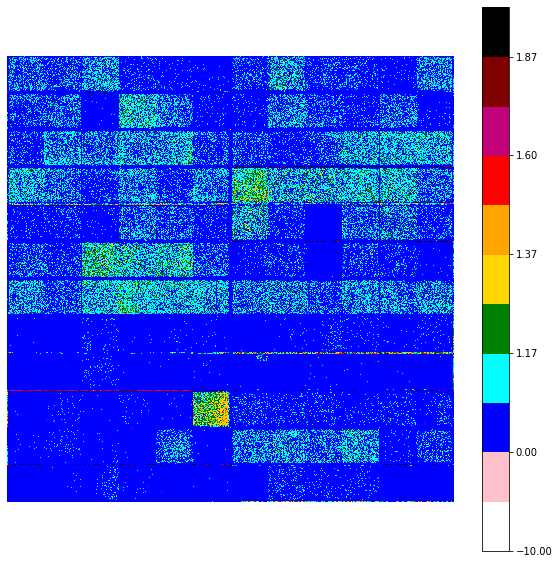

In [20]:
misc.imshow(data, (10,10))
misc.imshow(flat, (10,10))

array([-1.00000000e+01, -1.00000000e-01,  0.00000000e+00,  2.93009156e+00,
        8.58543657e+00,  2.51561152e+01,  7.37097210e+01,  2.15976232e+02,
        6.32830134e+02,  1.85425024e+03,  5.43312297e+03,  1.59195478e+04])

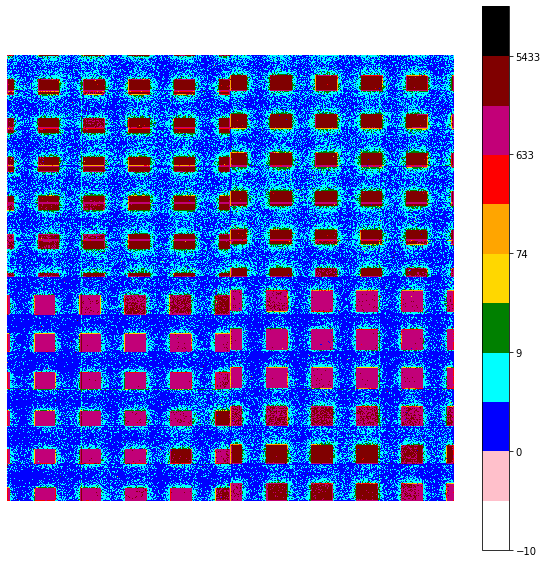

In [21]:
flat[flat == 0] = 1
flat[numpy.isnan(flat)] = 1

data = data*flat # Flatfield application. Convention with DET group is a product between data and flat!

misc.imshow( data, (10,10) )

In [22]:
distance = 300
params  = {'geo':'planar','opt':False,'mode':'real' }
project = pi540D.get_detector_dictionary( distance, params )
project['s'] = [ 0,0]

geometry = pi540D.geometry540D( project )

restored = pi540D.backward540D( data, geometry )

array([-1.00000000e+01, -1.00000000e-01,  0.00000000e+00,  2.56005268e+00,
        6.55386971e+00,  1.67782517e+01,  4.29532082e+01,  1.09962476e+02,
        2.81509730e+02,  7.20679739e+02,  1.84497810e+03,  4.72324111e+03])

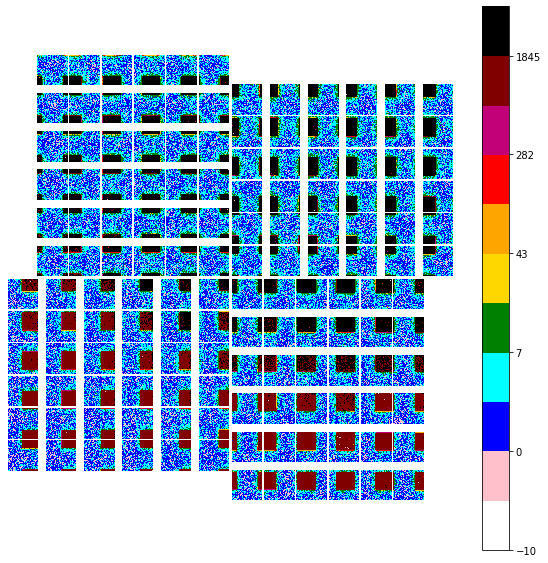

In [19]:
misc.imshow(restored, (10,10))

In [25]:
start = time.time()

print('--> Automatic annotation for 2 x LNLS template images ...')

annotation = pi540D._worker_LNLS_template_with_squares_( data )

#tracking_l_c, granular_l_c, trackdist_l_c = pi540D.tracking540D_from_LNLS_template ( data, 'center' ) 

--> Automatic annotation for 2 x LNLS template images ...


IndexError: index 128 is out of bounds for axis 1 with size 128

# Rationale for ssc-pimega/540D planar data (EMA) (GCC stuff)

In [ ]:
def get_module_strip (s):

    return s // 6,  s % 6
    
def set_module_strip (module, j):

    return j + 6 * module

def get_image_stripe_detector( img, m, s):
    #
    #Extract measure from a given module/stripe
    #
    #mathematical order
    s = 5 - s
    
    if m==0:
        out = img[s*256:(s+1)*256,0:1536]
    elif m==1:
        out= img[s*256:(s+1)*256,1536:3072]
    elif m==2:
        out = img[s*256+1536:(s+1)*256+1536,1536:3072]
    elif m==3:
        out = img[s*256+1536:(s+1)*256+1536,0:1536]        

    return out

###################

new = -1 * numpy.ones([4000,4000])

cr = new.shape[0]//2
cc = new.shape[1]//2
H  = 1536
J  = 256

g = numpy.array([[50, 50, 50, 50, 50,0],
                 [50, 50, 50, 50, 50,0],
                 [50, 50, 50, 50, 50,0],
                 [50, 50, 50, 50, 50,0]])

oy = numpy.array([[4,0,0,0,0,0],
                  [4,0,0,0,0,0],
                  [4,0,0,0,0,0],
                  [4,0,0,0,0,0]])

n = 5*3
ox = numpy.array([[-4,0,0,0,0,0],
                  [-4,0,0,0,0,0],
                  [-n-4,0,0,0,0,0],
                  [-n-4,0,0,0,0,0]])
    
_row_ = []
_col_ = []

def get_index_withgap(start, end ):
    gapchip = 3
    arr = []
    for k in range(6):
        start_ = end - 256 * (6-k) - (5 - k) * gapchip
        chip   = numpy.arange(start_,start_ + 256)
        arr.append( chip )    
    return numpy.array(arr).flatten()
    
for k in range(6):
    start_0 = cr - (k+1)*J - g[0][0:k].sum() - oy[0][k]
    end_0   = start_0 + J

    end_1   = cc + (k+1)*J + g[1][0:k].sum() + oy[1][k]
    start_1 = end_1 - J

    end_2   = cr + (k+1)*J + g[2][0:k].sum() + oy[2][k]
    start_2 = end_2 - J
    
    start_3 = cc - (k+1)*J - g[3][0:k].sum() - oy[3][k]
    end_3   = start_3 + J
    
    if k==5:
        _row_.append([start_0,end_2])
        _col_.append([end_1,start_3])
    
    idx = get_index_withgap(cc + ox[0][k] - H, cc + ox[0][k] )
    #not considering gap
    #new[ start_0:end_0, cc + ox[0][k] - H: cc + ox[0][k]] = get_image_stripe_detector(data,0,k)
    #considering gap
    new[ start_0:end_0, idx] = get_image_stripe_detector(data,0,k)

    idx = get_index_withgap(cr + ox[1][k] - H, cr + ox[1][k])
    #not considering gap
    #new[ cr + ox[1][k] - H:cr + ox[1][k], start_1: end_1 ] = numpy.flipud( get_image_stripe_detector(data,1,k) ).T
    #considering gap
    new[idx, start_1: end_1] = numpy.flipud( get_image_stripe_detector(data,1,k) ).T
    
    idx = get_index_withgap(cc - ox[2][k], cc - ox[2][k] + H)
    #not considering gap
    #new[ start_2: end_2, cc - ox[2][k]:cc - ox[2][k] + H ] =  numpy.fliplr( numpy.flipud( get_image_stripe_detector(data,2,k) ) )
    #considering gap
    new[ start_2: end_2, idx ] =  numpy.fliplr( numpy.flipud( get_image_stripe_detector(data,2,k) ) )
    
    idx = get_index_withgap( cc - ox[3][k], cc - ox[3][k] + H)
    #not considering gap
    #new[ cc - ox[3][k]:cc - ox[3][k] + H, start_3: end_3  ] =  numpy.flipud(numpy.fliplr( numpy.flipud( get_image_stripe_detector(data,3,k) ) )).T
    #considering gap
    new[ idx, start_3: end_3  ] =  numpy.flipud(numpy.fliplr( numpy.flipud( get_image_stripe_detector(data,3,k) ) )).T
    

_row_ = numpy.array(_row_).flatten()
_col_ = numpy.array(_col_).flatten()

nrows = max(_row_) - min(_row_)
ncols = max(_col_) - min(_col_)

print(nrows, ncols)

new[0:min(_row_),:] = 1
new[max(_row_):new.shape[0],:] = 1

new[:,0:min(_col_)] = 1
new[:,max(_col_):new.shape[1]] = 1


#roi = 256
#misc.imshow(new[new.shape[0]//2-roi:new.shape[0]//2+roi,new.shape[1]//2-roi:new.shape[1]//2+roi], (20,20))

misc.imshow(new, (20,20))

In [ ]:
def get_module_strip (s):

    return s // 6,  s % 6
    
def set_module_strip (module, j):

    return j + 6 * module

def get_image_stripe_detector( img, m, s):
    #
    #Extract measure from a given module/stripe
    #
    #mathematical order
    s = 5 - s
    
    if m==0:
        out = img[s*256:(s+1)*256,0:1536]
    elif m==1:
        out= img[s*256:(s+1)*256,1536:3072]
    elif m==2:
        out = img[s*256+1536:(s+1)*256+1536,1536:3072]
    elif m==3:
        out = img[s*256+1536:(s+1)*256+1536,0:1536]        

    return out

H  = 1536
J  = 256

def get_shape_pi540D_planar( ox, oy, g):

    _row_ = []
    _col_ = []
    
    for k in range(6):
        start_0 = cr - (k+1)*J - g[0][0:k].sum() - oy[0][k]
        end_0   = start_0 + J

        end_1   = cc + (k+1)*J + g[1][0:k].sum() + oy[1][k]
        start_1 = end_1 - J

        end_2   = cr + (k+1)*J + g[2][0:k].sum() + oy[2][k]
        start_2 = end_2 - J

        start_3 = cc - (k+1)*J - g[3][0:k].sum() - oy[3][k]
        end_3   = start_3 + J
    
        if k==5:
            _row_.append([start_0,end_2])
            _col_.append([end_1,start_3])

    _row_ = numpy.array(_row_).flatten()
    _col_ = numpy.array(_col_).flatten()
    
    nrows = max(_row_) - min(_row_)
    ncols = max(_col_) - min(_col_)

    rowv = [ min(_row_), max(_row_) ]
    colv = [ min(_col_), max(_col_) ]
    
    return (nrows,ncols), rowv, colv
    
    
g = numpy.array([[130, 20, 50, 100, 100,0],
                 [110, 20, 50, 100, 100,0],
                 [124, 20, 50, 100, 100,0],
                 [112, 20, 50, 100, 100,0]])

oy = numpy.array([[3,0,0,0,0,0],
                  [3,0,0,0,0,0],
                  [3,0,0,0,0,0],
                  [3,0,0,0,0,0]])

ox = numpy.array([[-3,-40,0,0,0,0],
                  [-3,-30,0,0,0,0],
                  [-3,-50,0,0,0,0],
                  [-3,-50,0,0,0,0]])


shape, rowv, colv = get_shape_pi540D_planar( ox, oy, g)

new = -1 * numpy.ones( [4000,4000])
cr = new.shape[0]//2
cc = new.shape[1]//2

LUT = ( numpy.zeros([24,J,H]), numpy.zeros([24,J,H]) ) 

for k in range(6):
    start_0 = cr - (k+1)*J - g[0][0:k].sum() - oy[0][k]
    end_0   = start_0 + J

    end_1   = cc + (k+1)*J + g[1][0:k].sum() + oy[1][k]
    start_1 = end_1 - J

    end_2   = cr + (k+1)*J + g[2][0:k].sum() + oy[2][k]
    start_2 = end_2 - J
    
    start_3 = cc - (k+1)*J - g[3][0:k].sum() - oy[3][k]
    end_3   = start_3 + J

    #module-0
    _ix_ = numpy.arange(cc + ox[0][k] - H, cc + ox[0][k])
    _iy_ = numpy.arange(start_0,end_0)
    [ix,iy] = numpy.meshgrid(_ix_, _iy_)
    ###print('0',iy.shape, ix.shape)
    LUT[0][ 0*6 + k] = ix
    LUT[1][ 0*6 + k] = iy
    
    #module-1
    _ix_ = numpy.arange(start_1, end_1)
    _iy_ = numpy.arange(cr + ox[1][k] - H, cr + ox[1][k])
    [iy,ix] = numpy.meshgrid(_iy_, _ix_)
    ###print('1',iy.shape, ix.shape)
    LUT[0][ 1*6 + k ] = numpy.flipud(ix)
    LUT[1][ 1*6 + k ] = numpy.flipud(iy)

    #module-2
    _ix_ = numpy.arange(cc - ox[2][k],cc - ox[2][k] + H)
    _iy_ = numpy.arange(start_2, end_2)
    [ix,iy] = numpy.meshgrid(_ix_, _iy_)
    ###print('2',iy.shape, ix.shape)
    LUT[0][ 2*6 + k ] = numpy.fliplr( numpy.flipud( ix ) )
    LUT[1][ 2*6 + k ] = numpy.fliplr( numpy.flipud( iy ) )

    #module-3
    _ix_ = numpy.arange(start_3, end_3)
    _iy_ = numpy.arange(cc - ox[3][k],cc - ox[3][k] + H)
    [iy,ix] = numpy.meshgrid(_iy_, _ix_)
    ###print('3',iy.shape, ix.shape)
    LUT[0][ 3*6 + k ] = numpy.flipud( numpy.fliplr( numpy.flipud( ix ) ) )
    LUT[1][ 3*6 + k ] = numpy.flipud( numpy.fliplr( numpy.flipud( iy ) ) )    
    
    
#############

nova = -1 * numpy.ones([4000,4000])

images = [  data[0:1536,0:1536], data[0:1536,1536:3072], data[1536:3072,1536:3072], data[1536:3072,0:1536] ]

for module in range(4):
     
    for j in range(6):
        
        s = set_module_strip( module, j )
            
        ix = LUT[0][s].astype(int)
        iy = LUT[1][s].astype(int)
    
        stripe = get_image_stripe_detector(data,module,j)
     
        nova[iy, ix] = stripe

misc.imshow(nova, (10,10))